<a href="https://colab.research.google.com/github/fluidefi/DeFi-Algorithmic-Trading/blob/main/api_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [ ]:
def auth(username, password):
    auth_token = requests.post(f"{HOST}/auth/", json={
        'username': username,
        'password': password
    }).json()
    return auth_token


def get_lp_returns(address, blockchain, currency_code, frequency, start_date, end_date):
    """
    Return per period from adding liquidity to a pool

    :param address: address of the liquidity pool
    :param blockchain: ETH for Ethereum, or BNB for Binance Smart Chain
    :param currency_code: Three letter code that represents the currency to compute in.
    :param frequency: How to summarize data during period: Hourly 'H', Daily 'D', Weekly 'W', Monthly 'M', or quarterly 'Q'
    :param start_date: ISO format date YYYY-MM-DD Example: 2022-06-01
    :param end_date:  'now' for the current day or ISO format date YYYY-MM-DD Example: 2022-06-07
    :return: pd.Series()
    """
    pool_data = requests.get(
        f'{HOST}/lp_details/{address}/{blockchain}/{currency_code}/{frequency}/{start_date}/{end_date}/',
        headers={"Authorization": f"Token {AUTH_TOKEN}"}
    ).json()
    pool_data = pd.DataFrame(pool_data)
    pool_data['open_timestamp_utc'] = pd.to_datetime(pool_data['open_timestamp_utc'])
    return pool_data.set_index('open_timestamp_utc')['total_period_return']


def lp_mom(pool_rets, lookback, rebalancing_frequency):
    """
    Executes a liquidity pool momentum strategy: Lookback lookback periods, invest now in the highest performing asset,
    repeat this every rebalancing_frequency periods
    
    :param pool_rets: A dataframe with the returns of more than one asset 
    :param lookback: How far to look back
    :param rebalancing_frequency: How frequently to rebalance the portfolio
    :return: pd.Series(), strategy returns
    """
    positions = pd.Series(dtype=str)
    for i in range(lookback, len(pool_rets), rebalancing_frequency):
        total_return = (pool_rets.iloc[i - lookback:i] + 1).prod() - 1
        positions.loc[pool_rets.index[i]] = total_return.idxmax()
    positions = pd.get_dummies(positions).reindex(pool_rets.index).ffill().dropna()
    return pool_rets.iloc[lookback:].multiply(positions, axis=1).sum(axis=1)

In [ ]:
HOST = "https://analytics.fluidefi.com"
AUTH_TOKEN = auth(username='your_username', password= 'your_password')

In [ ]:
start_date = "2021-01-01"
end_date = "2022-07-31"
frequency = "D"
currency = "USD"

In [ ]:
# Get the returns of USDC-USDT liquidity pool
usdc_usdt_returns = get_lp_returns(
    address='0x3041cbd36888becc7bbcbc0045e3b1f144466f5f',
    blockchain="ETH",
    currency_code=currency,
    frequency=frequency,
    start_date=start_date,
    end_date=end_date
)

# Get the returns of USDC-WETH liquidity pool
usdc_weth_returns = get_lp_returns(
    address='0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc',
    blockchain="ETH",
    currency_code=currency,
    frequency=frequency,
    start_date=start_date,
    end_date=end_date
)

In [ ]:
# Combine the returns into a single dataframe
returns = pd.concat([usdc_usdt_returns, usdc_weth_returns], axis=1)
returns.columns = ['usdc_usdt pool', 'usdc_weth pool']
# Let's see how the data looks like
returns.head()

,usdc_usdt pool,usdc_weth pool
open_timestamp_utc,,
2021-01-01,0.000330,-0.004571
2021-01-02,0.001795,0.032974
2021-01-03,-0.000184,0.123969
2021-01-04,0.001405,0.036431
2021-01-05,0.000150,0.029675


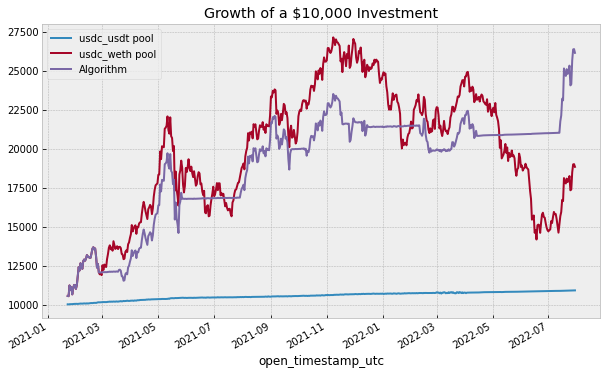

In [ ]:
# Execute the strategy and plot portfolio value
returns['Algorithm'] = lp_mom(returns, lookback=21, rebalancing_frequency=7)
((returns.dropna() + 1).cumprod() * 10000).plot(figsize=(10, 6), title="Growth of a $10,000 Investment")
plt.show()